In [1]:
from typing import Tuple

import numpy as np
import pathlib
import matplotlib.pyplot as plt
import tqdm
from scipy.fft import fft, fftfreq

In [2]:
ERA5_ROOT = pathlib.Path("/aspire/CarloData/zz_UNETs/data/big_dataset/ERA5/samples/test")
ERA5_VARS = ['u10', 'v10', 't2m', 'sshf', 'zust', ]

# ERA5_DX = 0.25  # deg
ERA5_DX = 30  # deg
era5_root = sorted(list(ERA5_ROOT.glob("*.npy")))

n_era5, m_era5, p_era5 = np.load(era5_root[0]).shape  # get shape of sample
len(era5_root), (n_era5, m_era5, p_era5), ERA5_DX

(1448, (81, 81, 15), 30)

In [3]:
CERRA_ROOT = pathlib.Path("/aspire/CarloData/zz_UNETs/data/big_dataset/CERRA/samples/test")
CERRA_VARS = ['u10', 'v10', 't2m', 'sshf', 'zust',]
cerra_files = sorted(list(CERRA_ROOT.glob("*.npy")))

n_cerra, m_cerra, p_cerra = np.load(cerra_files[0]).shape  # get shape of sample

# Compute grid spacing from ERA5 and shape of CERRA
CERRA_DX = ERA5_DX * (n_era5 / n_cerra)  # deg

len(cerra_files), (n_cerra, m_cerra, p_cerra), CERRA_DX

(1448, (368, 368, 5), 6.603260869565218)

In [4]:
preds_ROOT = pathlib.Path("/aspire/CarloData/zz_UNETs/data/big_dataset/preds/UNet-CNN-BigData-UNet-CNN-05_20_19-9299")
preds_files = sorted(list(preds_ROOT.glob("*.npy")))
p_preds, n_preds, m_preds = np.load(preds_files[0]).shape  # get shape of sample

# Compute grid spacing from ERA5 and shape of preds
preds_DX = ERA5_DX * (n_era5 / n_preds)  # deg

len(preds_files), (n_preds, m_preds, p_preds), preds_DX

(1448, (368, 368, 5), 6.603260869565218)

In [5]:
def get_psd(a: np.ndarray, *, dx: float, axis: int) -> Tuple[np.ndarray, np.ndarray]:
    # Number of samples in fft direction
    n = a.shape[axis]

    # Convert grid spacing to angular frequency
    dk = 2 * np.pi / dx
    k = np.arange(n // 2) * dk / n  # wavenumber space

    # Compute fft and power spectrum (only positive frequencies, ie half of FFT output)
    v_ft = fft(a, axis=axis)[..., :n // 2]
    v_psd = np.abs(v_ft) ** 2 / (n * dx)

    return k, v_psd


In [23]:
cerra_data = np.array([np.load(f) for f in tqdm.tqdm(cerra_files)])
preds_data = np.array([np.load(f) for f in tqdm.tqdm(preds_files)])
preds_data = preds_data.transpose(0, 2, 3, 1)
print(cerra_data.shape, preds_data.shape)

100%|██████████| 1448/1448 [00:03<00:00, 402.48it/s]


(1448, 368, 368, 5) (1448, 368, 368, 5)


In [24]:
# Again, compute psd in longitude direction (axis=2)
k_cerra, v_psd_cerra = get_psd(cerra_data[:, :, :, 2], dx=CERRA_DX, axis=2)
k_preds, v_psd_preds = get_psd(preds_data[:, :, :, 2], dx=preds_DX, axis=2)
print(k_cerra.shape, v_psd_cerra.shape)
print(k_preds.shape, v_psd_preds.shape)

(184,) (1448, 368, 184)
(184,) (1448, 368, 184)


In [31]:
u10_cerra = cerra_data[:, :, :, 0]
v10_cerra = cerra_data[:, :, :, 1]
u10_preds = preds_data[:, :, :, 0]
v10_preds = preds_data[:, :, :, 1]

m10_cerra = np.sqrt(u10_cerra ** 2 + v10_cerra ** 2)
m10_preds = np.sqrt(u10_preds ** 2 + v10_preds ** 2)

k_cerra, v_psd_cerra = get_psd(m10_cerra, dx=CERRA_DX, axis=2)
k_preds, v_psd_preds = get_psd(m10_preds, dx=preds_DX, axis=2)

print(k_cerra.shape, v_psd_cerra.shape)
print(k_preds.shape, v_psd_preds.shape)

(184,) (1448, 368, 184)
(184,) (1448, 368, 184)


In [32]:
# Average over longitudes
v_psd_cerra = v_psd_cerra.mean(axis=1)
v_psd_preds = v_psd_preds.mean(axis=1)
print(v_psd_cerra.shape, v_psd_preds.shape)

(1448, 184) (1448, 184)


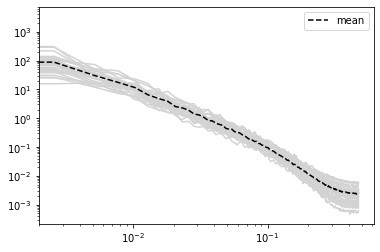

In [33]:
plt.plot(k_cerra, v_psd_cerra[::50].T, color="lightgrey")
plt.plot(k_cerra, v_psd_cerra.mean(axis=0), "k--", label="mean")
plt.legend()
plt.xscale("log")
plt.yscale("log")

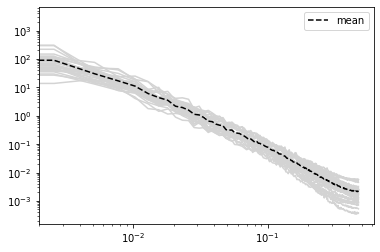

In [34]:
plt.plot(k_preds, v_psd_preds[::50].T, color="lightgrey")
plt.plot(k_preds, v_psd_preds.mean(axis=0), "k--", label="mean")
plt.legend()
plt.xscale("log")
plt.yscale("log")

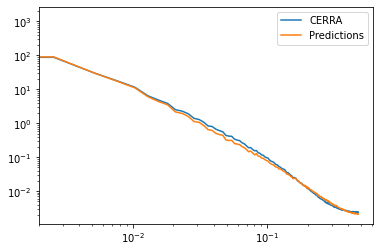

In [35]:
# Ideally, both cuves should start at the same y offset and have same x range. 
# Maybe something is wrong with the step size (dx). 
plt.plot(k_cerra, v_psd_cerra.mean(axis=0), label="CERRA")
plt.plot(k_preds, v_psd_preds.mean(axis=0), label="Predictions")
plt.legend()
plt.xscale("log")
plt.yscale("log")

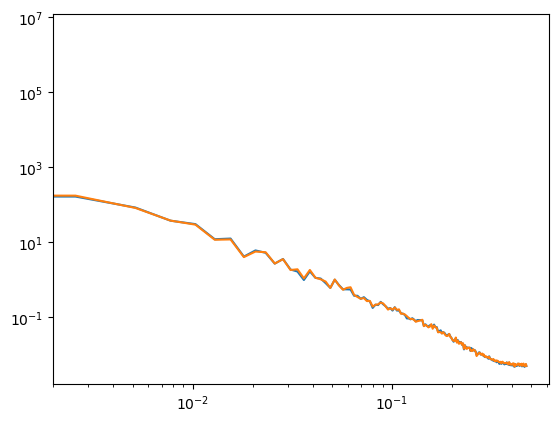

In [ ]:
# Example of comparing PSDs of samples
# Here, good overlap. We would expect larger difference between true and predict samples!
plt.plot(k_cerra, v_psd_cerra[0], label="CERRA sample 0")
plt.plot(k_cerra, v_psd_cerra[1], label="CERRA sample 0")
plt.xscale("log")
plt.yscale("log")